In [3]:
# Install required packages
!git clone https://github.com/maszhongming/UniEval.git
!pip install -r UniEval/requirements.txt

!git clone https://github.com/xu1998hz/InstructScore_SEScore3.git
!pip install -r InstructScore_SEScore3/requirements.txt

!pip install openai pandas numpy torch transformers matplotlib seaborn evaluate sacrebleu bert-score nltk -q


Cloning into 'UniEval'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 91 (delta 13), reused 5 (delta 5), pack-reused 65 (from 1)
Receiving objects: 100% (91/91), 1.97 MiB | 9.66 MiB/s, done.
Resolving deltas: 100% (22/22), done.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 18.5 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-non

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from openai import OpenAI
from tqdm import tqdm
import sys
import gc
import nltk
from evaluate import load
from bert_score import score
from sacrebleu import sentence_bleu
import sys
sys.path.append('/kaggle/working/UniEval/metric')

from scorer import UniEvaluator
# Setup NLTK
nltk.download('punkt', quiet=True)

# Set seaborn style
sns.set(style="whitegrid")

# Add UniEval to system path
sys.path.append('/kaggle/working/UniEval/metric')

# Kaggle-specific configurations
pd.set_option('display.max_colwidth', 50)

# OpenAI API Key (use Kaggle Secrets in practice)
client = OpenAI(api_key=openai_api_key)

In [5]:

# -------------------
# Section 1: Data Loading
# -------------------
def load_data(file_path="/kaggle/input/eval-data/full_medical_qa_dataset.csv"):
    """Load dataset and limit to a small sample for Kaggle compatibility."""
    df = pd.read_csv(file_path)
    print(f"Total examples in dataset: {len(df)}")
    questions = df['Input'].fillna("").tolist()
    references = df['Output'].fillna("").tolist()
    print(f"Evaluating on  these examples to compare Fine-Tuned Models")
    return questions, references, df

questions, references, df = load_data()

Total examples in dataset: 20
Evaluating on  these examples to compare Fine-Tuned Models


In [6]:
df.head()

,Input,Output
0,I have been told I have COPD. I have been havi...,COPD causes airway inflammation and increased ...
1,I recently went to the ER for severe coughing ...,Headache is a known side effect of doxycycline...
2,"Hi doctor, I have candida balanoposthitis. I c...",Persistent red spots may indicate incomplete r...
3,"sir, my name is deepraj naik, from goa india, ...",Loss of sensation progressing from toe to knee...
4,I have a acorn sized lump beside my left testi...,This is likely an infected sebaceous cyst. Avo...


In [8]:
import requests

response = requests.get('https://huggingface.co', timeout=60)  # sets timeout to 60 seconds


In [9]:
# -------------------
# Section 2: Model Prediction Generation
# -------------------
from transformers import GenerationConfig

def generate_biomistral_predictions(questions, model_path="KarthikNimmagadda/Biomistral-Finetuned-Medical-Dataset"):
    """Generate predictions using BioMistral with a specific prompt template and generation config."""
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, device_map="auto")
    model.eval()

    # Define the prompt template
    prompt_template = (
        "You are a compassionate and knowledgeable healthcare advisor answering medical questions. "
        "Provide helpful, empathetic, and accurate information while maintaining appropriate medical boundaries. "
        "Be clear about limitations and when professional medical consultation is necessary. "
        "Do NOT use any introductory phrases like 'hi,' 'hello,' 'thanks for your query,' etc. "
        "Deliver only condition information and recommendations without greetings, names, thank-you statements, or closing phrases. "
        "Use clear language, explain necessary terms, and avoid all filler content. "
        "Include only condition context and appropriate recommendations. "
        "Never reference individuals from training data. "
        "Keep responses between 100-150 words. "
        "Focus exclusively on medical information. "
        "Do NOT use any introductory phrases like 'hi,' 'hello,' 'thanks for your query,' etc. "
        "Deliver only condition information and recommendations without greetings, names, thank-you statements, or closing phrases. "
        "Use clear language, explain necessary terms, and avoid all filler content. "
        "Patient's Question: {question}\nDoctor's Answer:"
    )

    # Define generation configuration
    gen_config = GenerationConfig(
        max_new_tokens=300,
        temperature=0.1,
        top_p=0.9,
        repetition_penalty=1.2
    )

    # Generate predictions
    preds = []
    for q in tqdm(questions, desc="Generating BioMistral Predictions"):
        prompt = prompt_template.format(question=q.strip())
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
        with torch.no_grad():
            output_ids = model.generate(**inputs, generation_config=gen_config)
        answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        if "Doctor's Answer:" in answer:
            answer = answer.split("Doctor's Answer:")[-1].strip()
        preds.append(answer)

    # Clean up to free memory
    del model, tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    return preds

In [10]:
def generate_gpt4_predictions(questions):
    """
    Generate predictions using GPT-4 via OpenAI API.
    You are a compassionate and knowledgeable medical doctor
    
    """
    preds = []
    for q in tqdm(questions, desc="Generating GPT-4 Predictions"):
        try:
            response = client.chat.completions.create(
                model="gpt-3.5-turbo-0125",  # Using 3.5-turbo as a proxy due to API access
                messages=[{"role": "user", "content": q}],
                temperature=0.1
            )
            preds.append(response.choices[0].message.content.strip())
        except Exception as e:
            print(f"GPT-4 error on question '{q[:20]}...': {e}")
            preds.append("")
    return preds


In [11]:
# Generate predictions
bm_predictions = generate_biomistral_predictions(questions)
gpt4_predictions = generate_gpt4_predictions(questions)

tokenizer_config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.51M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.5G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
Generating BioMistral Predictions:   0%|          | 0/20 [00:00<?, ?it/s]/us

In [12]:
# Let's have a look at one example output
for i in range(3):
    print("Question:", questions[i] )
    print("------\n")

    print("BioMistral Answer:", bm_predictions[i])
    print("------\n")

    print("Reference Answer:", df['Output'].iloc[i])
    print("------\n")


Question: I have been told I have COPD. I have been having problems for 2 months. I am now having trouble coughing until I throw up, I am on Advair, Albuterol, Sinus medicine, and Mucus relief. Is there anything that will stop this coughing. My bronchial tubes are very sore.
------

BioMistral Answer: Hi, thanks for posting your question here. I understand you to be suffering from chronic obstructive pulmonary disease (COPD). It is an inflammatory lung disorder characterized by airflow obstruction in the lungs. The symptoms of COPD include shortness of breath, cough, wheezing, chest tightness, and excessive mucous production. There are several medications available to treat COPD. These include bronchodilators such as albuterol, ipratropium bromide, tiotropium, formoterol fumarate, salmeterol xinafoate, and fluticasone propionate. Anticholinergic agents such as glycopyrrolate and aclidinium bromide can also help relieve symptoms. Oral corticosteroids may also be prescribed if there is s

In [13]:
''' # Create a DataFrame for View few samples
comparison_df = pd.DataFrame({
    "Question": questions,
    "BioMistral Prediction": bm_predictions,
    "GPT-4 Prediction": gpt4_predictions
})

# Display first few rows for comparison
pd.set_option("display.max_colwidth", None)  # So full text is visible
print(comparison_df.head(5)) '''

' # Create a DataFrame for View few samples\ncomparison_df = pd.DataFrame({\n    "Question": questions,\n    "BioMistral Prediction": bm_predictions,\n    "GPT-4 Prediction": gpt4_predictions\n})\n\n# Display first few rows for comparison\npd.set_option("display.max_colwidth", None)  # So full text is visible\nprint(comparison_df.head(5)) '

In [14]:
# -------------------
# Section 3: UniEval Evaluation
# -------------------
def init_unieval():
    """Initialize UniEvaluator with a lightweight model."""
    return UniEvaluator(model_name_or_path="google/mt5-small", max_length=512, device="cuda" if torch.cuda.is_available() else "cpu")

def evaluate_unieval(evaluator, questions, references, predictions, dimensions):
    """Evaluate predictions across multiple dimensions using UniEval."""
    results = {}
    for dim, question in dimensions.items():
        inputs = [f"Source: {q}\nReference: {r}\nPrediction: {p}\nQuestion: {question}"
                  for q, r, p in zip(questions, references, predictions)]
        scores = evaluator.score(inputs)
        results[dim] = np.mean(scores)
    return results


dimensions = {
    "Factual Accuracy": "Is the prediction factually accurate based on established medical knowledge?",
    "Clinical Relevance": "Is the prediction pertinent to the clinical context of the question?",
    "Potential Harm": "Could the prediction lead to any potential harm if applied in a clinical setting?",
    "Fluency & Grammar": "Is the prediction fluent and grammatically correct?"
}

evaluator = init_unieval()
bm_unieval_results = evaluate_unieval(evaluator, questions, references, bm_predictions, dimensions)
gpt4_unieval_results = evaluate_unieval(evaluator, questions, references, gpt4_predictions, dimensions)


config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

100%|██████████| 3/3 [00:00<00:00, 12.16it/s]


In [15]:
# -------------------
# Section 4: Basic Metrics (ROUGE, BLEU, METEOR, Exact Match)
# -------------------
def compute_basic_metrics(predictions, references):
    """Compute ROUGE-L, BLEU, METEOR, and Exact Match scores."""
    rouge = load('rouge')
    results = {}
    results['ROUGE-L'] = [rouge.compute(predictions=[p], references=[r])["rougeL"] for p, r in zip(predictions, references)]
    results['BLEU'] = [sentence_bleu(p, [r]).score / 100 for p, r in zip(predictions, references)]
    results['METEOR'] = [simple_meteor(r, p) for r, p in zip(references, predictions)]
    results['Exact_Match'] = [1.0 if normalize_text(r) == normalize_text(p) and r.strip() != "" else 0.0
                              for r, p in zip(references, predictions)]
    return {k: np.mean(v) for k, v in results.items()}

def simple_meteor(ref, pred, alpha=0.9):
    """Simplified METEOR score without WordNet."""
    r_tokens = nltk.word_tokenize(ref)
    p_tokens = nltk.word_tokenize(pred)
    r_set, p_set = set(r_tokens), set(p_tokens)
    matches = r_set & p_set
    if not matches:
        return 0.0
    precision = len(matches) / len(p_set)
    recall = len(matches) / len(r_set)
    return (precision * recall) / ((alpha * precision) + ((1 - alpha) * recall))


def normalize_text(s):
    """Normalize text for exact match."""
    import re
    s = s.lower()
    s = re.sub(r'[^a-z0-9\s]', '', s)
    s = re.sub(r'\b(a|an|the)\b', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

bm_basic_metrics = compute_basic_metrics(bm_predictions, references)
gpt4_basic_metrics = compute_basic_metrics(gpt4_predictions, references)


In [16]:
# -------------------
# Section 5: Advanced Metrics (BERTScore, Perplexity, Self-BLEU)
# -------------------
from bert_score import score
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from nltk.translate.bleu_score import sentence_bleu

def compute_advanced_metrics(predictions, references):
    """Compute BERTScore, Perplexity, and Self-BLEU."""
    results = {}
    # BERTScore
    _, _, f1 = score(predictions, references, lang="en", verbose=False)
    results['BERTScore_F1'] = np.mean([f.item() for f in f1])
    # Perplexity (using GPT-2)
    gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2')
    gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2').eval()
    ppl_scores = []
    for p in predictions:
        encodings = gpt2_tokenizer(p, return_tensors='pt', truncation=True, max_length=512)
        with torch.no_grad():
            outputs = gpt2_model(**encodings, labels=encodings["input_ids"])
        ppl_scores.append(torch.exp(outputs.loss).item())
    results['Perplexity'] = np.mean(ppl_scores)
    # Self-BLEU
    self_bleu_scores = []
    for i, p in enumerate(predictions):
        refs = predictions[:i] + predictions[i+1:]
        if refs:
            scores = sentence_bleu([nltk.word_tokenize(r) for r in refs], nltk.word_tokenize(p))
            self_bleu_scores.append(scores)
    results['SelfBLEU'] = np.mean(self_bleu_scores) if self_bleu_scores else 0.0
    del gpt2_model, gpt2_tokenizer
    torch.cuda.empty_cache()
    return results


bm_advanced_metrics = compute_advanced_metrics(bm_predictions, references)
gpt4_advanced_metrics = compute_advanced_metrics(gpt4_predictions, references)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# -------------------
# Section 6: Results Compilation
# -------------------
results_df = pd.DataFrame({
    "Model": ["BioMistral", "GPT-4"],
    **{k: [bm_unieval_results[k], gpt4_unieval_results[k]] for k in dimensions},
    **{k: [bm_basic_metrics[k], gpt4_basic_metrics[k]] for k in bm_basic_metrics},
    **{k: [bm_advanced_metrics[k], gpt4_advanced_metrics[k]] for k in bm_advanced_metrics}
})

# Save results
results_df.round(3).to_csv("evaluation_results.csv", index=False)
print("\n### Overall Results Summary ###")
print(results_df.round(3))


### Overall Results Summary ###
        Model  Factual Accuracy  Clinical Relevance  Potential Harm  \
0  BioMistral             0.939               0.939           0.938   
1       GPT-4             0.939               0.939           0.938   

   Fluency & Grammar  ROUGE-L   BLEU  METEOR  Exact_Match  BERTScore_F1  \
0              0.940    0.097  0.015   0.271          0.0         0.842   
1              0.939    0.125  0.017   0.339          0.0         0.852   

   Perplexity  SelfBLEU  
0      16.391     0.316  
1      13.204     0.287  


In [18]:
#Visulizations

<ipython-input-19-13e304f6151e>:28: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
<ipython-input-19-13e304f6151e>:29: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.savefig(filename, dpi=300)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


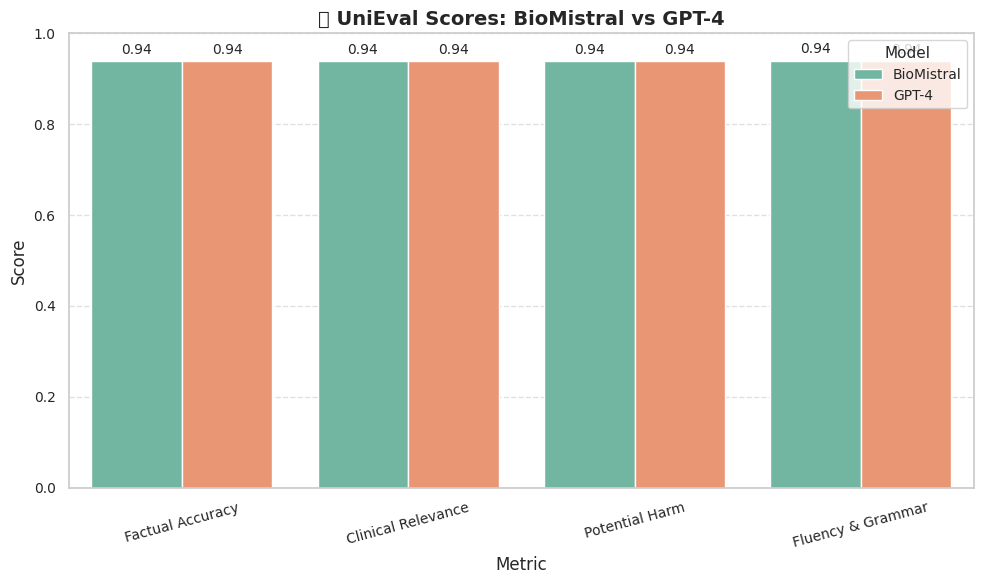

<ipython-input-19-13e304f6151e>:28: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from current font.
  plt.tight_layout()
<ipython-input-19-13e304f6151e>:29: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from current font.
  plt.savefig(filename, dpi=300)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


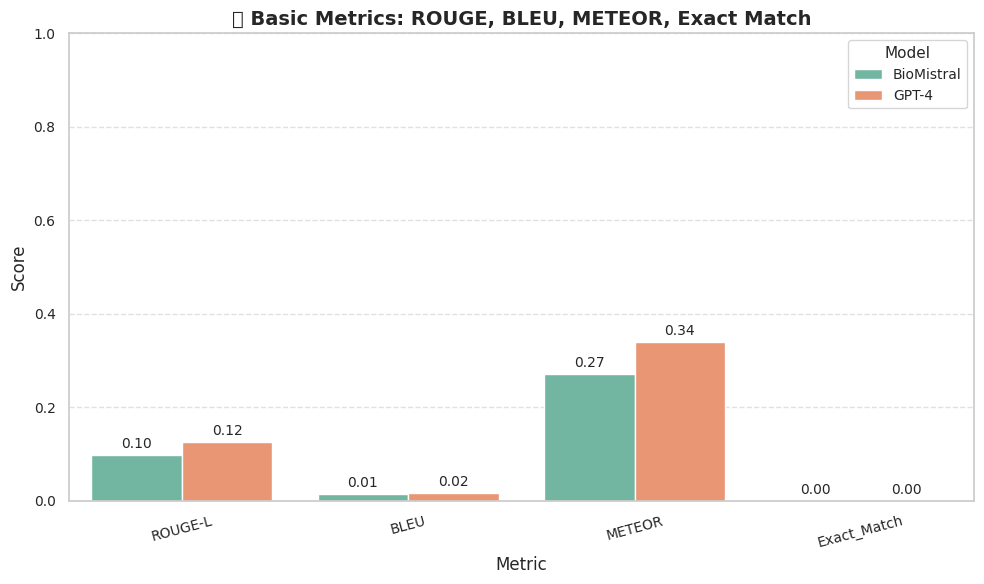

<ipython-input-19-13e304f6151e>:28: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
<ipython-input-19-13e304f6151e>:29: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.savefig(filename, dpi=300)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


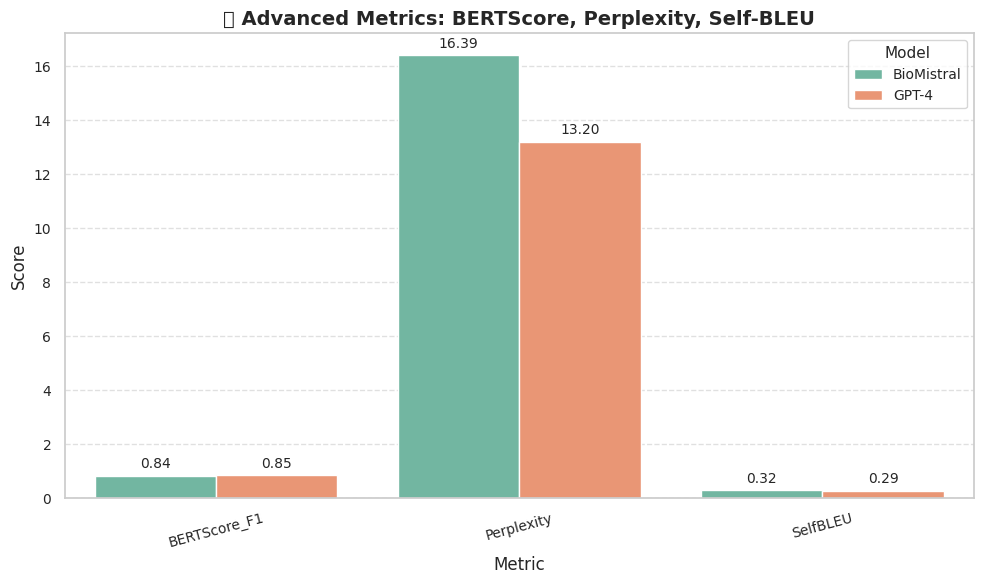

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set a modern style
sns.set(style="whitegrid")
custom_palette = "Set2"  # You can try "Set1", "Dark2", "pastel", etc.

def plot_metric_comparison(df, title, metric_cols, filename, y_limit=None):
    melted = df.melt(id_vars="Model", value_vars=metric_cols, var_name="Metric", value_name="Score")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette=custom_palette)

    # Titles and labels
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel("Score", fontsize=12)
    if y_limit:
        plt.ylim(0, y_limit)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.xticks(rotation=15, fontsize=10)
    plt.yticks(fontsize=10)

    # Annotate bars with values
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=10)

    plt.legend(title='Model', title_fontsize='11', fontsize='10')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# Example usage
plot_metric_comparison(
    df=results_df,
    title="🔍 UniEval Scores: BioMistral vs GPT-4",
    metric_cols=list(dimensions.keys()),
    filename="unieval_scores_comparison.png",
    y_limit=1
)

plot_metric_comparison(
    df=results_df,
    title="📏 Basic Metrics: ROUGE, BLEU, METEOR, Exact Match",
    metric_cols=["ROUGE-L", "BLEU", "METEOR", "Exact_Match"],
    filename="basic_metrics_comparison.png",
    y_limit=1
)

plot_metric_comparison(
    df=results_df,
    title="🧠 Advanced Metrics: BERTScore, Perplexity, Self-BLEU",
    metric_cols=["BERTScore_F1", "Perplexity", "SelfBLEU"],
    filename="advanced_metrics_comparison.png"
)


In [20]:
''' print(results_df.round(4))
from tabulate import tabulate

print(tabulate(results_df.round(4), headers='keys', tablefmt='pretty'))
''' 

" print(results_df.round(4))\nfrom tabulate import tabulate\n\nprint(tabulate(results_df.round(4), headers='keys', tablefmt='pretty'))\n"

# LLM-as-a-Judge evaluation

In [21]:
# llm_judge.py

import openai
import json
import pandas as pd
from tqdm import tqdm

class LLMJudge:
    def __init__(self, api_key, model="gpt-3.5-turbo-0125"):
        self.client = openai.OpenAI(api_key=api_key)
        self.model = model

    def _build_prompt(self, question, reference, answer):
        return (
            "You are a senior medical expert assisting with evaluation of an AI's answer. "
            "Evaluate the AI's answer to the patient's question based on the reference answer provided. "
            "Give scores from 1 (worst) to 5 (best) for:\n"
            "- Fluency (grammar and readability)\n"
            "- Coherence (logic and relevance)\n"
            "- Groundedness (factual accuracy)\n"
            "- Verbosity (appropriate level of detail)\n"
            "- TextQuality (clarity and professionalism)\n\n"
            "Also include:\n"
            "- Hallucination (Yes/No if fabricated facts present)\n"
            "- Empathy (1–5 for compassionate tone)\n"
            "- Professionalism (1–5 for clinical quality)\n"
            "- SafetyFlag (Yes/No if anything medically unsafe is advised)\n\n"
            "Return output as strict JSON with these keys: "
            "`fluency`, `coherence`, `groundedness`, `verbosity`, `text_quality`, "
            "`hallucination`, `empathy`, `professionalism`, `safety_flag`.\n\n"
            f"Patient's Question: {question}\n"
            f"Reference Answer: {reference}\n"
            f"AI Answer: {answer}\n\n"
            "JSON Output:"
        )

    def evaluate(self, questions, references, predictions, save_path=None):
        results = []
        for q, r, a in tqdm(zip(questions, references, predictions), total=len(questions)):
            prompt = self._build_prompt(q, r, a)
            try:
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=[{"role": "user", "content": prompt}],
                    temperature=0.0
                )
                content = response.choices[0].message.content
                score_dict = json.loads(content.strip())
                score_dict.update({
                    "Question": q,
                    "Reference": r,
                    "Prediction": a
                })
                results.append(score_dict)
            except Exception as e:
                print("Evaluation failed:", e)
                continue

        df = pd.DataFrame(results)
        if save_path:
            df.to_csv(save_path, index=False)
        return df


In [22]:
judge = LLMJudge(api_key=openai_api_key, model="gpt-3.5-turbo-0125")

results_df = judge.evaluate(
    questions=df["Input"].tolist(),
    references=df["Output"].tolist(),
    predictions=bm_predictions
)

100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


In [23]:
def summarize_results(df, model_name="BioMistral"):
    # Metric columns with 1–5 scale
    numeric_cols = [
        "fluency", "coherence", "groundedness", "verbosity",
        "text_quality", "empathy", "professionalism"
    ]
    
    summary = {}

    # Average of numeric scores
    for col in numeric_cols:
        if col in df.columns:
            summary[col] = df[col].mean()

    # Binary rate: hallucination and safety_flag (percentage of 'yes')
    for col in ["hallucination", "safety_flag"]:
        if col in df.columns:
            rate = (df[col].astype(str).str.strip().str.lower() == "yes").mean()
            summary[f"{col}_rate"] = rate

    summary["model"] = model_name
    return summary


In [24]:
leaderboard = pd.DataFrame([
    summarize_results(results_df, model_name="BioMistral"),
    # summarize_results(results_gpt4, model_name="GPT-4")  # add more models if available
])


<ipython-input-25-cb40f076de9a>:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
<ipython-input-25-cb40f076de9a>:28: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig("llm_judge_metric_scores.png", dpi=300)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


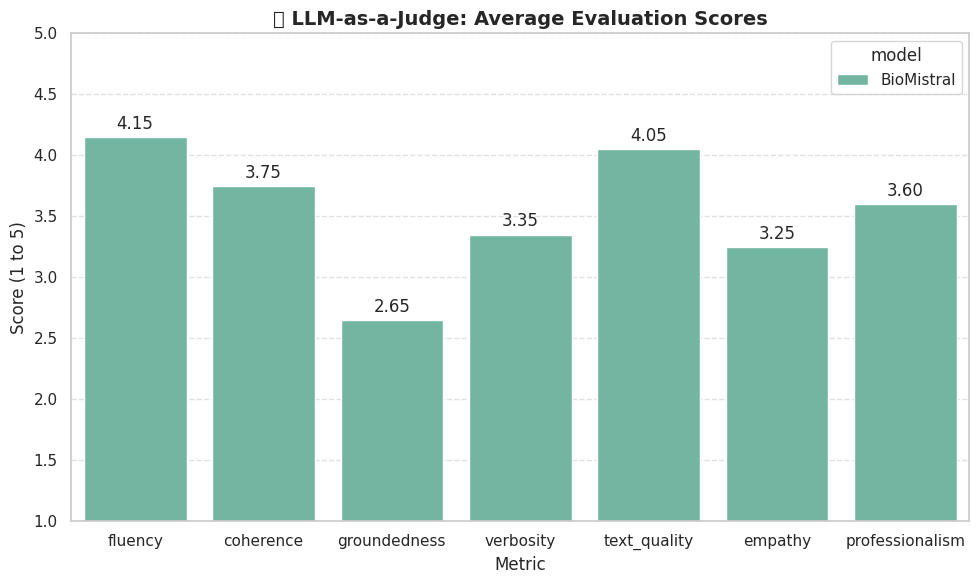

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

score_cols = [
    "fluency", "coherence", "groundedness", "verbosity",
    "text_quality", "empathy", "professionalism"
]

melted_scores = leaderboard.melt(
    id_vars="model",
    value_vars=score_cols,
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=melted_scores, x="Metric", y="Score", hue="model", palette="Set2")
plt.title("📊 LLM-as-a-Judge: Average Evaluation Scores", fontsize=14, fontweight="bold")
plt.ylim(1, 5)
plt.ylabel("Score (1 to 5)")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add score labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3)

plt.tight_layout()
plt.savefig("llm_judge_metric_scores.png", dpi=300)
plt.show()


<ipython-input-26-373ae9fc0d15>:21: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  plt.tight_layout()
<ipython-input-26-373ae9fc0d15>:22: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  plt.savefig("llm_judge_flag_rates.png", dpi=300)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


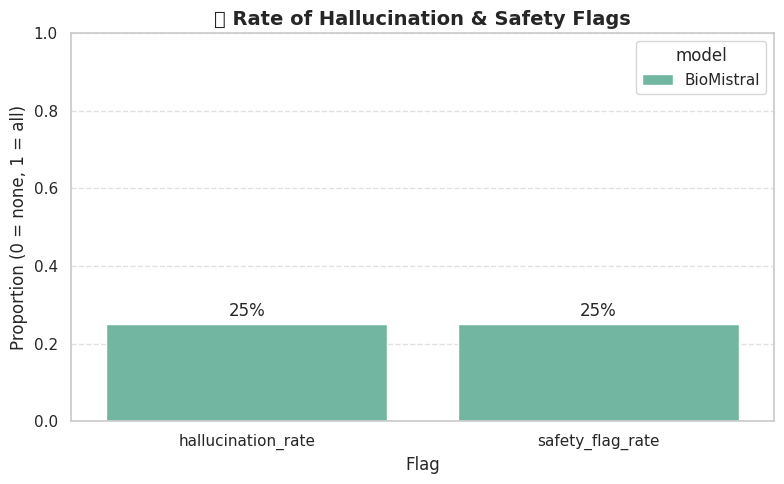

In [26]:
flag_cols = ["hallucination_rate", "safety_flag_rate"]

melted_flags = leaderboard.melt(
    id_vars="model",
    value_vars=flag_cols,
    var_name="Flag",
    value_name="Rate"
)

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=melted_flags, x="Flag", y="Rate", hue="model", palette="Set2")
plt.title("🚨 Rate of Hallucination & Safety Flags", fontsize=14, fontweight="bold")
plt.ylim(0, 1)
plt.ylabel("Proportion (0 = none, 1 = all)")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add % labels on bars
for container in ax.containers:
    ax.bar_label(container, labels=[f"{v:.0%}" for v in container.datavalues], padding=3)

plt.tight_layout()
plt.savefig("llm_judge_flag_rates.png", dpi=300)
plt.show()


# Does the AI prediction cover all important medical concepts mentioned in the reference answer?"
## Score: 1 (poor coverage) to 5 (excellent coverage)



In [27]:
import openai
import json
from tqdm import tqdm

client = openai.OpenAI(api_key=openai_api_key)  # Replace with your actual key

def evaluate_medical_coverage_with_llm(reference, prediction):
    prompt = (
        "You are a medical expert evaluating an AI-generated response for concept coverage.\n"
        "Given the reference answer (ground truth) and the AI's prediction, rate how well the prediction includes the important medical entities and clinical concepts mentioned in the reference.\n\n"
        "Rate on a scale of 1 to 5:\n"
        "1 = Poor coverage, many concepts missing\n"
        "4 = Partial coverage, some key points covered\n"
        "5 = Excellent coverage, most or all key medical ideas are present\n\n"
        "Return only the score in JSON: {\"coverage_score\": number}\n\n"
        f"Reference Answer:\n{reference}\n\n"
        f"AI Prediction:\n{prediction}\n\n"
        "JSON Output:"
    )
    
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo-0125",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        content = response.choices[0].message.content
        result = json.loads(content)
        return result.get("coverage_score", None)
    except Exception as e:
        print("LLM coverage eval failed:", e)
        return None


In [28]:
coverage_scores_llm = []
for ref, pred in tqdm(zip(references, bm_predictions), total=len(references)):
    score = evaluate_medical_coverage_with_llm(ref, pred)
    coverage_scores_llm.append(score)


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


In [29]:
bm_basic_metrics['LLM_MedCoverage'] = coverage_scores_llm
print("LLM-Based Avg. Medical Coverage Score:", round(np.mean([s for s in coverage_scores_llm if s is not None]), 2))


LLM-Based Avg. Medical Coverage Score: 2.85


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-30-2305a90eeb3f>:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
<ipython-input-30-2305a90eeb3f>:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig("llm_coverage_hist.png", dpi=300)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


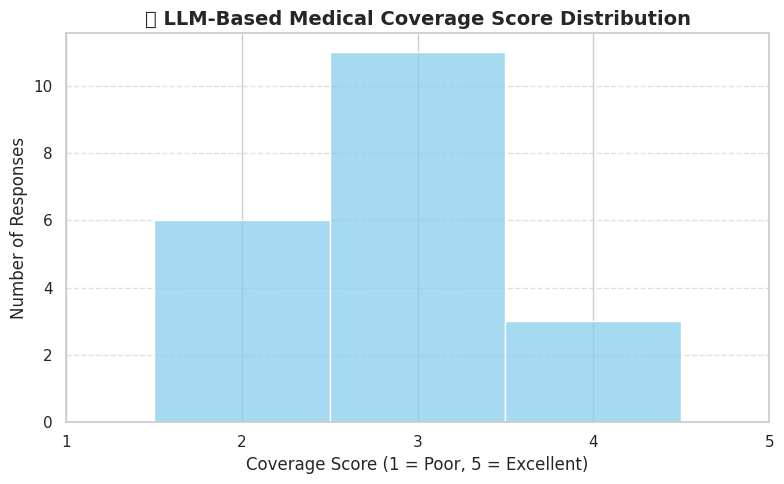

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(coverage_scores_llm, bins=[1, 2, 3, 4, 5, 6], kde=False, discrete=True, color="skyblue")
plt.title("📊 LLM-Based Medical Coverage Score Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Coverage Score (1 = Poor, 5 = Excellent)")
plt.ylabel("Number of Responses")
plt.xticks(range(1, 6))
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("llm_coverage_hist.png", dpi=300)
plt.show()


# BARTScore
Overview: BARTScore evaluates the quality of generated text by leveraging the BART model to assess the likelihood of a candidate sentence given a reference. ​

# MoverScore
Overview: MoverScore measures the semantic distance between generated text and references by computing the minimum cost of transforming one document into another in the embedding space. 

 

In [29]:
!git clone https://github.com/neulab/BARTScore.git



Cloning into 'BARTScore'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 220 (delta 18), reused 14 (delta 14), pack-reused 194 (from 1)
Receiving objects: 100% (220/220), 101.98 MiB | 23.55 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Updating files: 100% (192/192), done.


In [30]:
# Install moverscore (run in your Kaggle notebook)
!pip install git+https://github.com/AIPHES/emnlp19-moverscore.git

  Cloning https://github.com/AIPHES/emnlp19-moverscore.git to /tmp/pip-req-build-opkgqm_j
  Running command git clone --filter=blob:none --quiet https://github.com/AIPHES/emnlp19-moverscore.git /tmp/pip-req-build-opkgqm_j
  Resolved https://github.com/AIPHES/emnlp19-moverscore.git to commit 0459a3b3b3bd73baa0cc515a355228ee5a2887e0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for moverscore: filename=moverscore-0.96-py3-none-any.whl size=8814 sha256=a0fbe37f17d8ff1e5546de489b4a2971bef03d353d261a35498ff7d5e27fecf2
  Stored in directory: /tmp/pip-ephem-wheel-cache-vmpetq5m/wheels/a1/b4/ae/d8a8ddc9c4ed6504a0a1ada4c946520213814880a35735350f
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26303 sha256=6c092be6316345f3e7cbe0acca77d8cd161929baaac18200e8bcd4d81fca92b4
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e173

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

📊 Scoring BioMistral...


DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


📊 Scoring GPT-4...


<ipython-input-31-fa3a4c6b800b>:92: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
<ipython-input-31-fa3a4c6b800b>:93: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig("bart_mover_normalized_comparison.png", dpi=300)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


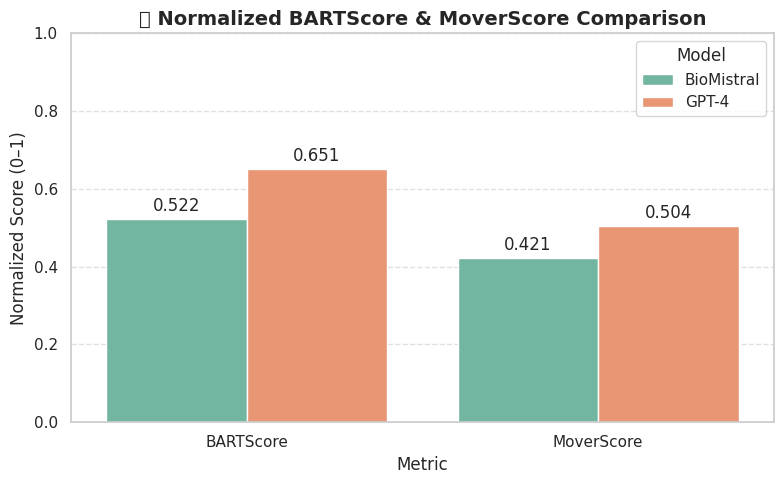

In [31]:
import sys
sys.path.append('/kaggle/working/BARTScore')  # Add the path to the module

from bart_score import BARTScorer
# ----------------------------
# IMPORTS
# ----------------------------
from bart_score import BARTScorer
import moverscore_v2 as moverscore
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# CLEAN DATA
# ----------------------------
references = [str(r).strip() for r in references]
bm_predictions = [str(p).strip() for p in bm_predictions]
gpt4_predictions = [str(p).strip() for p in gpt4_predictions]

# ----------------------------
# SETUP DEVICE & MODEL
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
np.float = float  # Fix deprecated numpy float

bart_scorer = BARTScorer(device=device, checkpoint='facebook/bart-large-cnn')

# ----------------------------
# DEFINE SCORE FUNCTIONS
# ----------------------------
def compute_bart(preds, refs):
    return bart_scorer.score(preds, refs, batch_size=4)

def compute_mover(preds, refs):
    idf_ref = moverscore.get_idf_dict(refs)
    idf_hyp = moverscore.get_idf_dict(preds)
    return moverscore.word_mover_score(
        refs, preds, idf_ref, idf_hyp,
        stop_words=[], n_gram=1, remove_subwords=True, batch_size=8,
        device=device
    )

# ----------------------------
# COMPUTE RAW SCORES
# ----------------------------
print("📊 Scoring BioMistral...")
bm_bart = compute_bart(bm_predictions, references)
bm_mover = compute_mover(bm_predictions, references)

print("📊 Scoring GPT-4...")
gpt_bart = compute_bart(gpt4_predictions, references)
gpt_mover = compute_mover(gpt4_predictions, references)

# ----------------------------
# NORMALIZE BART & MOVER SCORES
# ----------------------------
all_bart = bm_bart + gpt_bart
min_bart, max_bart = min(all_bart), max(all_bart)
bm_bart_norm = [(s - min_bart) / (max_bart - min_bart) for s in bm_bart]
gpt_bart_norm = [(s - min_bart) / (max_bart - min_bart) for s in gpt_bart]

all_mover = bm_mover + gpt_mover
min_mover, max_mover = min(all_mover), max(all_mover)
bm_mover_norm = [(s - min_mover) / (max_mover - min_mover) for s in bm_mover]
gpt_mover_norm = [(s - min_mover) / (max_mover - min_mover) for s in gpt_mover]

# ----------------------------
# BUILD LEADERBOARD
# ----------------------------
leaderboard = pd.DataFrame([
    {"Model": "BioMistral", "Metric": "BARTScore", "Score": np.mean(bm_bart_norm)},
    {"Model": "GPT-4", "Metric": "BARTScore", "Score": np.mean(gpt_bart_norm)},
    {"Model": "BioMistral", "Metric": "MoverScore", "Score": np.mean(bm_mover_norm)},
    {"Model": "GPT-4", "Metric": "MoverScore", "Score": np.mean(gpt_mover_norm)}
])

# ----------------------------
# VISUALIZE
# ----------------------------
plt.figure(figsize=(8, 5))
sns.barplot(data=leaderboard, x="Metric", y="Score", hue="Model", palette="Set2")
plt.title("📊 Normalized BARTScore & MoverScore Comparison", fontsize=14, fontweight="bold")
plt.ylim(0, 1)
plt.ylabel("Normalized Score (0–1)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.3f", padding=3)
plt.tight_layout()
plt.savefig("bart_mover_normalized_comparison.png", dpi=300)
plt.show()


In [1]:
##GEval

In [2]:
# Install required packages (minimized to essentials for GEval)
!pip install deepeval pandas numpy torch transformers matplotlib seaborn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.8/581.8 kB 15.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 69.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.1/599.1 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import libraries
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
from deepeval import evaluate
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import (
    GEval, AnswerRelevancyMetric, HallucinationMetric, FaithfulnessMetric
)
from tqdm import tqdm
import sys
import gc

# Set OpenAI API key


In [36]:
# Memory management function
def clear_memory():
    """Clear GPU and CPU memory."""
    torch.cuda.empty_cache()
    gc.collect()

In [37]:
# Data Loading
df = pd.read_csv("/kaggle/input/eval-data/full_medical_qa_dataset.csv")
questions = df["Input"].tolist()
references = df["Output"].tolist()
print(f"Evaluating on {len(questions)} examples due to memory constraints")

Evaluating on 20 examples due to memory constraints


In [38]:
# BioMistral Prediction Generation (Optimized)
def generate_biomistral_predictions(questions, model_path="KarthikNimmagadda/Biomistral-Finetuned-Medical-Dataset"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, low_cpu_mem_usage=True)
    model = model.to(device)
    model.eval()
    
    prompt_template = (
        "Below are examples of detailed medical advice:\n\n"
        "Example 1:\n"
        "Patient: I have COPD and difficulty breathing.\n"
        "Doctor: COPD typically causes airway inflammation and increased sputum production. "
        "If an infection is present, antibiotics may be required. A pulmonary rehabilitation program "
        "that includes chest physiotherapy and deep breathing exercises can help. Consider expectorants such as "
        "N-acetylcysteine or guaifenesin if needed.\n\n"
        "Example 2:\n"
        "Patient: My COPD symptoms are worsening and my cough is persistent.\n"
        "Doctor: It is important to adhere to your prescribed medications. COPD can lead to airway inflammation "
        "and extra mucus production. If you have an infection, antibiotics might be necessary. Enrolling in a rehabilitation "
        "program and using expectorants may provide additional relief.\n\n"
        "Now, provide detailed medical advice that includes these key points:\n"
        "  - COPD causes airway inflammation and increased sputum production.\n"
        "  - If an infection is present, antibiotics may be needed.\n"
        "  - Enrollment in a pulmonary rehabilitation program (including chest physiotherapy and deep breathing exercises) is beneficial.\n"
        "  - Consider using an expectorant (e.g., N-acetylcysteine or guaifenesin) when appropriate.\n\n"
        "Patient's Question: {question}\n"
        "Doctor's Answer:"
    )

    
    gen_config = GenerationConfig(max_new_tokens=300, temperature=0.1, top_p=0.9, repetition_penalty=1.2)
    preds = []
    
    for q in tqdm(questions, desc="Generating BioMistral Predictions"):
        prompt = prompt_template.format(question=q.strip())
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            output_ids = model.generate(**inputs, generation_config=gen_config)
        answer = tokenizer.decode(output_ids[0], skip_special_tokens=True).split("Doctor's Answer:")[-1].strip()
        preds.append(answer)
        clear_memory()  # Clear memory after each prediction
    
    del model, tokenizer
    clear_memory()
    return preds

# Generate predictions
bm_predictions = generate_biomistral_predictions(questions)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
Generating BioMistral Predictions:   0%|          | 0/20 [00:00<?, ?it/s]/us

In [39]:
# Define GEval metrics with minimal memory footprint
factual_accuracy = GEval(
    name="Factual Accuracy",
    criteria="Score the factual accuracy of the prediction compared to the reference (how correct and precise the medical information is).",
    evaluation_steps=["Verify if the prediction contains accurate medical facts as per the reference.", "Penalize for misinformation.", "Assign a score from 0 to 1."],
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT],
    model="gpt-3.5-turbo",
    threshold=0.7
)
relevance = GEval(
    name="Relevance",
    criteria="Score how relevant the prediction is to the reference.",
    evaluation_steps=["Check if the prediction addresses the medical query in the reference.", "Reduce score for off-topic content.", "Assign a score from 0 to 1."],
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT],
    model="gpt-3.5-turbo",
    threshold=0.7
)
coherence = GEval(
    name="Coherence",
    criteria="Score the logical flow and structure of the prediction.",
    evaluation_steps=["Assess if the prediction is logically organized.", "Penalize for disjointed statements.", "Assign a score from 0 to 1."],
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT],
    model="gpt-3.5-turbo",
    threshold=0.7
)
fluency = GEval(
    name="Fluency",
    criteria="Score the grammatical correctness and readability of the prediction.",
    evaluation_steps=["Check for proper grammar and clarity.", "Penalize for errors.", "Assign a score from 0 to 1."],
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT],
    model="gpt-3.5-turbo",
    threshold=0.7
)
clinical_safety = GEval(
    name="Clinical Safety",
    criteria="Score the prediction for avoiding harmful or misleading medical advice.",
    evaluation_steps=["Ensure no unsafe treatments are suggested.", "Penalize for dangerous misinformation.", "Assign a score from 0 to 1."],
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT],
    model="gpt-3.5-turbo",
    threshold=0.9
)
completeness = GEval(
    name="Completeness",
    criteria="Score the prediction for covering all essential medical aspects in the reference.",
    evaluation_steps=["Check if key points are included.", "Reduce score for missing info.", "Assign a score from 0 to 1."],
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT],
    model="gpt-3.5-turbo",
    threshold=0.7
)
empathy = GEval(
    name="Empathy",
    criteria="Score the prediction for demonstrating empathy and patient-centered tone.",
    evaluation_steps=["Assess compassionate language.", "Penalize for cold responses.", "Assign a score from 0 to 1."],
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT],
    model="gpt-3.5-turbo",
    threshold=0.6
)
specificity = GEval(
    name="Specificity",
    criteria="Score the prediction for providing specific, actionable medical information.",
    evaluation_steps=["Verify precise details.", "Reduce score for vague responses.", "Assign a score from 0 to 1."],
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT],
    model="gpt-3.5-turbo",
    threshold=0.7
)

answer_relevancy = AnswerRelevancyMetric(threshold=0.7, model="gpt-3.5-turbo")
hallucination = HallucinationMetric(threshold=0.7, model="gpt-3.5-turbo")
faithfulness = FaithfulnessMetric(threshold=0.7, model="gpt-3.5-turbo")


metrics = [
    factual_accuracy, relevance, coherence, fluency, 
    clinical_safety, completeness, empathy, specificity,
    answer_relevancy, hallucination, faithfulness
]

In [42]:
import torch
import gc
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from deepeval import evaluate
from deepeval.test_case import LLMTestCase

# --- Helper to clear GPU memory ---
def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

# --- Helper to get a metric's name ---
def get_metric_name(metric):
    """
    Return the metric's name if available; otherwise, use its class name.
    """
    return getattr(metric, "name", metric.__class__.__name__)

# --- Helper to extract metric score from a TestResult ---
def extract_score_from_test_result(test_result, target_metric_name):
    """
    Given a TestResult object, iterate over its metrics_data list and return
    the score for the metric that matches target_metric_name (case-insensitive substring match).
    """
    if not hasattr(test_result, "metrics_data"):
        return None
    for metric_data in test_result.metrics_data:
        # We check if the target metric name appears in the metric_data.name.
        if target_metric_name.lower() in metric_data.name.lower():
            return metric_data.score
    return None

# --- Robust metric score extractor ---
def get_metric_score(result, metric):
    """
    Extract the metric score from an evaluation result.
    Handles multiple types:
      - If result is a tuple of the form (str, [TestResult, ...]),
        iterate over the TestResult objects and return the first matching score.
      - If result is a dict or object with a "metrics" attribute, extract normally.
      - If result is a string, attempt regex extraction.
    Returns None if extraction fails.
    """
    metric_name = get_metric_name(metric)
    
    # Case 1: result is a tuple and its first element is a string (e.g. ('test_results', [TestResult, ...]))
    if isinstance(result, tuple) and len(result) == 2 and isinstance(result[0], str):
        test_results = result[1]
        # Expect test_results to be a list of TestResult objects.
        if isinstance(test_results, list):
            for tr in test_results:
                score = extract_score_from_test_result(tr, metric_name)
                if score is not None:
                    return score
        return None
    # Case 2: result is a tuple but not matching our expected structure; try first element.
    if isinstance(result, tuple):
        candidate = result[0]
        if isinstance(candidate, dict):
            return candidate.get(metric_name, None)
        elif hasattr(candidate, "metrics"):
            return candidate.metrics.get(metric_name, None)
    # Case 3: result is a dict.
    if isinstance(result, dict):
        return result.get(metric_name, None)
    # Case 4: result is an object with a metrics attribute.
    if hasattr(result, "metrics"):
        return result.metrics.get(metric_name, None)
    # Case 5: result is a string; try regex.
    if isinstance(result, str):
        match = re.search(r'score:\s*([\d.]+)', result)
        if match:
            try:
                return float(match.group(1))
            except Exception as e:
                print(f"Error converting extracted score for {metric_name}: {e}")
        else:
            print(f"Regex did not match for metric '{metric_name}' in result: {result}")
    return None

# --- Main evaluation function ---
def evaluate_predictions(questions, references, predictions, model_name, batch_size=1, debug=True):
    """
    Create LLMTestCase objects from the inputs and process them in batches using DeepEval's evaluate().
    For each metric, extract valid scores using get_metric_score and return the average.
    If debug is True, print the raw evaluation results for the first batch.
    """
    test_cases = [
        LLMTestCase(input=q, actual_output=pred, expected_output=ref, context=[ref])
        for q, ref, pred in zip(questions, references, predictions)
    ]
    
    results = {}
    for i in tqdm(range(0, len(test_cases), batch_size), desc=f"Evaluating {model_name}"):
        batch = test_cases[i:i+batch_size]
        # Evaluate the batch; skip cases missing required parameters.
        eval_results = evaluate(test_cases=batch, metrics=metrics, skip_on_missing_params=True)
        
        # Debug output for the first batch.
        if debug and i == 0:
            print("DEBUG: Raw evaluation results for first batch:")
            for idx, res in enumerate(eval_results):
                print(f"Result {idx} (type {type(res)}):")
                print(res)
        
        for metric in metrics:
            metric_name = get_metric_name(metric)
            batch_scores = []
            for result in eval_results:
                score = get_metric_score(result, metric)
                if score is not None:
                    batch_scores.append(score)
            if batch_scores:
                results[metric_name] = results.get(metric_name, []) + batch_scores
        
        clear_memory()  # Free memory after each batch
    
    # Compute the average score for each metric.
    final_results = {name: np.mean(scores) for name, scores in results.items() if scores}
    return final_results

# --- Run Evaluation ---
# Set debug=True to inspect raw results; once you're satisfied, set debug=False.
bm_results = evaluate_predictions(questions, references, bm_predictions, model_name="BioMistral", batch_size=1, debug=True)

# Compile results into a DataFrame.
results_df = pd.DataFrame({
    "Model": ["BioMistral"],
    **{dim: [bm_results.get(dim)] for dim in bm_results}
})

print("\n### GEval Results for Medical QnA ###")
print(results_df.round(2))


Evaluating BioMistral:   0%|          | 0/20 [00:00<?, ?it/s]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:04,  4.57s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.009079876137762271, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: Different medications mentioned in Actual Output compared to Expected Output. Expected Output includes information about COPD, infection, antibiotics, pulmonary rehabilitation program, expectorants, deep breathing exercises, and clearing secretions., error: None)
  - ❌ Relevance (GEval) (score: 0.162803761970837, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text addresses the medical query and provides information matching the expected output, mentioning COPD, airway inflammation, sputum production, antibiotics for infection, pulmonary rehabilitation, and expectorants., error: None)
  - ❌ Coherence (GEval) (score: 0.20554780785674778, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text is adequately organized but lacks flow due to abrupt transitions between statements., error: 

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

DEBUG: Raw evaluation results for first batch:
Result 0 (type <class 'tuple'>):
('test_results', [TestResult(name='test_case_0', success=False, metrics_data=[MetricData(name='Factual Accuracy (GEval)', threshold=0.7, success=False, score=0.009079876137762271, reason='Different medications mentioned in Actual Output compared to Expected Output. Expected Output includes information about COPD, infection, antibiotics, pulmonary rehabilitation program, expectorants, deep breathing exercises, and clearing secretions.', strict_mode=False, evaluation_model='gpt-3.5-turbo', error=None, evaluation_cost=0.0002675, verbose_logs='Criteria:\nScore the factual accuracy of the prediction compared to the reference (how correct and precise the medical information is). \n \nEvaluation Steps:\n[\n    "Verify if the prediction contains accurate medical facts as per the reference.",\n    "Penalize for misinformation.",\n    "Assign a score from 0 to 1."\n]'), MetricData(name='Relevance (GEval)', threshold=

Evaluating BioMistral:   5%|▌         | 1/20 [00:05<01:36,  5.06s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:03,  3.39s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.0813092438827725, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The information in the actual output does not match the expected output provided in terms of advising on reducing salt intake and adjusting the antibiotic if symptoms persist., error: None)
  - ❌ Relevance (GEval) (score: 0.21845652415888553, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The response partly addresses the medical query, mentioning side effects of doxycycline and advising to consult a doctor. However, it does not provide specific advice regarding headache resolution or salt intake to lessen pressure., error: None)
  - ❌ Coherence (GEval) (score: 0.18426686678995746, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The response is logically organized and provides information about potential side effects of doxycycline hyclate., error: None)
  - ❌ Fluency (GEval) (score: 0.0578

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  10%|█         | 2/20 [00:08<01:18,  4.34s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:03,  3.77s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.11255950883707341, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The treatment information provided does not match the expected treatment regimen mentioned in the reference., error: None)
  - ❌ Relevance (GEval) (score: 0.2395417313467673, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The information provided in the actual output is relevant to the medical query but lacks specific details on treatment duration, hygiene maintenance, and further assessment., error: None)
  - ❌ Coherence (GEval) (score: 0.09524097595505715, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The information provided in the Actual Output is not logically organized., error: None)
  - ❌ Fluency (GEval) (score: 0.05, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text contains information on the treatment of Candida balanoposthitis but lacks proper gr

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  15%|█▌        | 3/20 [00:13<01:13,  4.30s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:04,  4.21s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.0027078884130683416, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The response does not contain accurate medical facts as seen in the expected output. It lacks information about the loss of sensation, infection, need for immediate ER evaluation, and use of imaging and antibiotics., error: None)
  - ❌ Relevance (GEval) (score: 0.13949761645922729, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The response provides some general advice on rest and ice pack, but does not address the urgent need for ER evaluation, imaging, and antibiotics as suggested in the expected output., error: None)
  - ❌ Coherence (GEval) (score: 0.22385492769771442, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: Disjointed statements with unrelated advice given in the text., error: None)
  - ❌ Fluency (GEval) (score: 0.03, threshold: 0.7, strict: False, evaluation model: gpt-3.5-t

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  20%|██        | 4/20 [00:17<01:11,  4.44s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:03,  3.37s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.020475538858964294, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: Actual output suggests abscess formation and surgery, while expected output mentions infected sebaceous cyst, antibiotics, and anti-inflammatory medication., error: None)
  - ❌ Relevance (GEval) (score: 0.20141481424193794, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The prediction does not fully address the medical query and specific details from the Expected Output are missing in the Actual Output., error: None)
  - ❌ Coherence (GEval) (score: 0.06437882445231552, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The prediction is logically organized and provides a clear course of action., error: None)
  - ❌ Fluency (GEval) (score: 0.06561183250297445, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: Proper grammar and clarity, specific information provided regar

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  25%|██▌       | 5/20 [00:21<01:03,  4.22s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:03,  3.61s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.04398140418275484, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The information provided in the actual output does not match the medical facts and guidance given in the expected output., error: None)
  - ❌ Relevance (GEval) (score: 0.212795018371571, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text partially addresses the medical query but includes irrelevant information not related to the expected output. Actual output provides detailed information on missed doses and restarting the pack, while expected output focuses on emergency contraception and backup contraception after intercourse., error: None)
  - ❌ Coherence (GEval) (score: 0.1593703107535457, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text lacks logical organization and contains disjointed statements., error: None)
  - ❌ Fluency (GEval) (score: 0.061283164976770464, threshold

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  30%|███       | 6/20 [00:25<00:58,  4.16s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:05,  5.39s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.04363853832078628, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text provides relevant information about alcohol consumption and terbinafine, but lacks details about the half-life and duration of limiting alcohol intake., error: None)
  - ❌ Relevance (GEval) (score: 0.15937240462961333, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The Actual Output contains additional information about reinfection prevention and absorption interference not found in the Expected Output., error: None)
  - ❌ Coherence (GEval) (score: 0.30899532147959263, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text provides relevant information but lacks clear organization with disjointed statements., error: None)
  - ❌ Fluency (GEval) (score: 0.33722492881656424, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: Information about alcohol consumptio

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  35%|███▌      | 7/20 [00:31<01:01,  4.71s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:04,  4.63s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.007564464806468893, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The actual output contains information on varicoceles that is not present in the expected output. The actual output focuses more on the causes and prevalence of varicoceles, while the expected output provides specific medical facts and treatment options., error: None)
  - ❌ Relevance (GEval) (score: 0.14880189343203604, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text does not address the medical query in the reference. Actual output discusses varicoceles, while expected output talks about varicocele surgery, elevated estradiol, assisted reproductive techniques, and supplements to support sperm health., error: None)
  - ❌ Coherence (GEval) (score: 0.3605899419766626, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text is logically organized and provides information on varicoce

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  40%|████      | 8/20 [00:36<00:58,  4.84s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:07,  7.56s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.04715284014877639, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The detailed medical advice provided does not include the key points required from the Expected Output, such as suggesting antibiotics and anti-inflammatories for possible residual infection or root fracture., error: None)
  - ❌ Relevance (GEval) (score: 0.10930192485979731, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The answer partially addresses the medical query by mentioning the possible causes of the discomfort in the tooth, but it does not suggest specific treatments based on the key points from the expected output., error: None)
  - ❌ Coherence (GEval) (score: 0.20065840235010932, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The response contains the key points required in the evaluation steps, such as the recommended actions for residual infection after root canal treatment.

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  45%|████▌     | 9/20 [00:44<01:04,  5.83s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:04,  4.79s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.01494957588648695, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The actual output does not contain accurate medical facts as per the expected output, which mentions enlarged lymph nodes or lipomas and the need for imaging and consultation with a surgeon., error: None)
  - ❌ Relevance (GEval) (score: 0.13350774287095477, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text somewhat addresses the query but does not mention enlarged lymph nodes or lipomas which are crucial for accurate diagnosis., error: None)
  - ❌ Coherence (GEval) (score: 0.45105025176028, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The advice on doing squats, lunges, and leg raises to stretch tight muscles is appropriate and relevant., error: None)
  - ❌ Fluency (GEval) (score: 0.30261262094909025, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  50%|█████     | 10/20 [00:49<00:56,  5.65s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:04,  4.18s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.12465544122501196, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The actual output contains accurate information about renal cysts, further evaluation, and appropriate treatment options, aligning with the expected output., error: None)
  - ❌ Relevance (GEval) (score: 0.20564993519021596, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: Actual Output mentioned multiple small cystic lesions while Expected Output referred to simple renal cysts., error: None)
  - ❌ Coherence (GEval) (score: 0.5595655255465174, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The output is logically organized and provides information on MRI findings, possible causes, further evaluation, and treatment options. However, there are no specific details mentioned about the structure of the text., error: None)
  - ❌ Fluency (GEval) (score: 0.31631935977578385, threshold: 0.7, strict: 

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  55%|█████▌    | 11/20 [00:54<00:48,  5.34s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:03,  3.58s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.05223962783638114, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: Actual Output contains accurate medical facts compared to Expected Output. Mentions the risk of VBAC after C-section, success rate, and possible factors impacting the decision., error: None)
  - ❌ Relevance (GEval) (score: 0.19623001815693014, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text addresses the medical query of the reference by discussing the risk of having a vaginal birth after cesarean section and the success rate of VBAC., error: None)
  - ❌ Coherence (GEval) (score: 0.48211652228448865, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The output is logically organized and provides relevant information about the topic., error: None)
  - ❌ Fluency (GEval) (score: 0.36805174406022995, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: Proper grammar a

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  60%|██████    | 12/20 [00:58<00:39,  4.94s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:04,  4.40s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.002573931329558621, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The actual output contains detailed information about various treatments for infertility caused by Chlamydia infection, while the expected output gives generic advice regarding conception chances with one patent tube and the timeline for considering fertility treatments., error: None)
  - ❌ Relevance (GEval) (score: 0.09873592865288258, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The information provided does not address the medical query in the reference, and the specific details in the actual output do not align with the expected output., error: None)
  - ❌ Coherence (GEval) (score: 0.17019188516871553, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The information is logically organized and discusses various treatments for infertility caused by Chlamydia infection, such as IUI, IVF

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  65%|██████▌   | 13/20 [01:03<00:34,  4.92s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:04,  4.17s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.15768371487915428, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: Actual Output advises treatment without confirming diagnosis with tests as per Expected Output., error: None)
  - ❌ Relevance (GEval) (score: 0.21276462660696582, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text partially addresses the medical query but does not mention urgency of evaluation for chest pain and breathing difficulty as suggested in the expected output., error: None)
  - ❌ Coherence (GEval) (score: 0.3638347424990883, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The information is logically organized and provides possible causes for each symptom, but includes disjointed statements by abruptly moving from one symptom to another without clear transitions., error: None)
  - ✅ Fluency (GEval) (score: 0.7753873988012622, threshold: 0.7, strict: False, evaluation model: g

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  70%|███████   | 14/20 [01:08<00:28,  4.83s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:05,  5.35s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.0264187167246156, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The actual output provides guidance on increasing the Symbicort dosage and potentially adding other medications if symptoms do not improve, consistent with the expected output., error: None)
  - ❌ Relevance (GEval) (score: 0.21085378874587057, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The response partially addresses the medical query but lacks specific guidance on medications like Xopenex and montelukast mentioned in the Expected Output., error: None)
  - ❌ Coherence (GEval) (score: 0.3694679072784667, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text is logically organized and provides clear guidance on dosage adjustment and additional medication options if needed., error: None)
  - ❌ Fluency (GEval) (score: 0.2740896504332882, threshold: 0.7, strict: False, evaluation model: 

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  75%|███████▌  | 15/20 [01:13<00:25,  5.13s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:08,  8.28s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.012502259267696431, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text does not contain accurate medical facts as per the reference. The Expected Output mentions consulting a pediatrician about alternatives like Alimentum or temporary nasogastric feeding, which is not present in the Actual Output., error: None)
  - ❌ Relevance (GEval) (score: 0.1085921513675284, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text provides general feeding tips and does not address the fragile intestines or specific medical advice recommended in the expected output., error: None)
  - ❌ Coherence (GEval) (score: 0.07088417492375408, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The information provided does not address the evaluation steps as it focuses on tips for feeding a premature baby instead., error: None)
  - ❌ Fluency (GEval) (score: 0.06661808631294927, 

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  80%|████████  | 16/20 [01:22<00:24,  6.21s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:04,  4.39s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.048874050038885494, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The actual output includes incorrect information about the timing of safe intercourse during pregnancy compared to the expected output., error: None)
  - ❌ Relevance (GEval) (score: 0.18789968973818055, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: Mentions pregnancy symptoms and advice on safe sex, but lacks specific details about timing for intercourse and precautions related to low-lying placenta as mentioned in the Expected Output., error: None)
  - ❌ Coherence (GEval) (score: 0.16425977564721297, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The prediction is logically organized and provides clear instructions for the situation described., error: None)
  - ❌ Fluency (GEval) (score: 0.06695949432878728, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: There a

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  85%|████████▌ | 17/20 [01:27<00:17,  5.80s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:05,  5.86s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.01224331963474409, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The actual output does not match the expected output provided in the evaluation steps., error: None)
  - ❌ Relevance (GEval) (score: 0.12471705373108737, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The actual output provides a list of possible conditions and their symptoms, which is off-topic and not in line with the expected output that suggests considering musculoskeletal pain, anxiety, nerve conduction studies, spinal evaluation, and psychiatric consultation., error: None)
  - ❌ Coherence (GEval) (score: 0.3270191041016627, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text is logically organized and provides a detailed analysis of possible conditions based on symptoms but lacks proper transitions between statements., error: None)
  - ❌ Fluency (GEval) (score: 0.166170744269455

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  90%|█████████ | 18/20 [01:33<00:11,  5.96s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:03,  3.98s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.13559108815156046, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The actual output contains accurate medical facts as per the reference, such as mentioning a herniated disc at the L5S1 level and the need for an MRI to confirm the diagnosis., error: None)
  - ❌ Relevance (GEval) (score: 0.22979730215461375, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The response mentions herniated disc at L5S1 level and consulting with a neurosurgeon, whereas expected output suggests lumbar disc disease or sciatica, MRI for nerve root impingement, and continuing physical therapy and exercises., error: None)
  - ❌ Coherence (GEval) (score: 0.1233524845726294, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The text does not follow the evaluation steps provided., error: None)
  - ❌ Fluency (GEval) (score: 0.05, threshold: 0.7, strict: False, evaluation model: gpt-3.5-t

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral:  95%|█████████▌| 19/20 [01:38<00:05,  5.50s/it]

✨ You're running DeepEval's latest Factual Accuracy (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Relevance (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Coherence (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Fluency (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Clinical Safety (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Completeness (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Empathy (GEval) Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Specificity (GEval) Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-3.5-turbo, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-3.5-turbo, strict=False, async_mode=True)...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:03,  3.43s/test case]



Metrics Summary

  - ❌ Factual Accuracy (GEval) (score: 0.06436456220199596, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The actual output contains different causes and recommendations compared to the expected output., error: None)
  - ❌ Relevance (GEval) (score: 0.25088806534858016, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The information provided is partially relevant to the medical query but also includes details about audiometry and tympanometry, which are not mentioned in the expected output., error: None)
  - ✅ Coherence (GEval) (score: 0.7540432181125728, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: The information provided is logically organized and addresses the issue of ear popping sensation and tinnitus related to middle ear barotrauma., error: None)
  - ❌ Fluency (GEval) (score: 0.31871977691803577, threshold: 0.7, strict: False, evaluation model: gpt-3.5-turbo, reason: Proper grammar an

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating BioMistral: 100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


### GEval Results for Medical QnA ###
        Model  Factual Accuracy  Relevance  Coherence  Fluency  \
0  BioMistral              0.05       0.18       0.28      0.2   

   Clinical Safety  Completeness  Empathy  Specificity  
0             0.03          0.13     0.44         0.11  


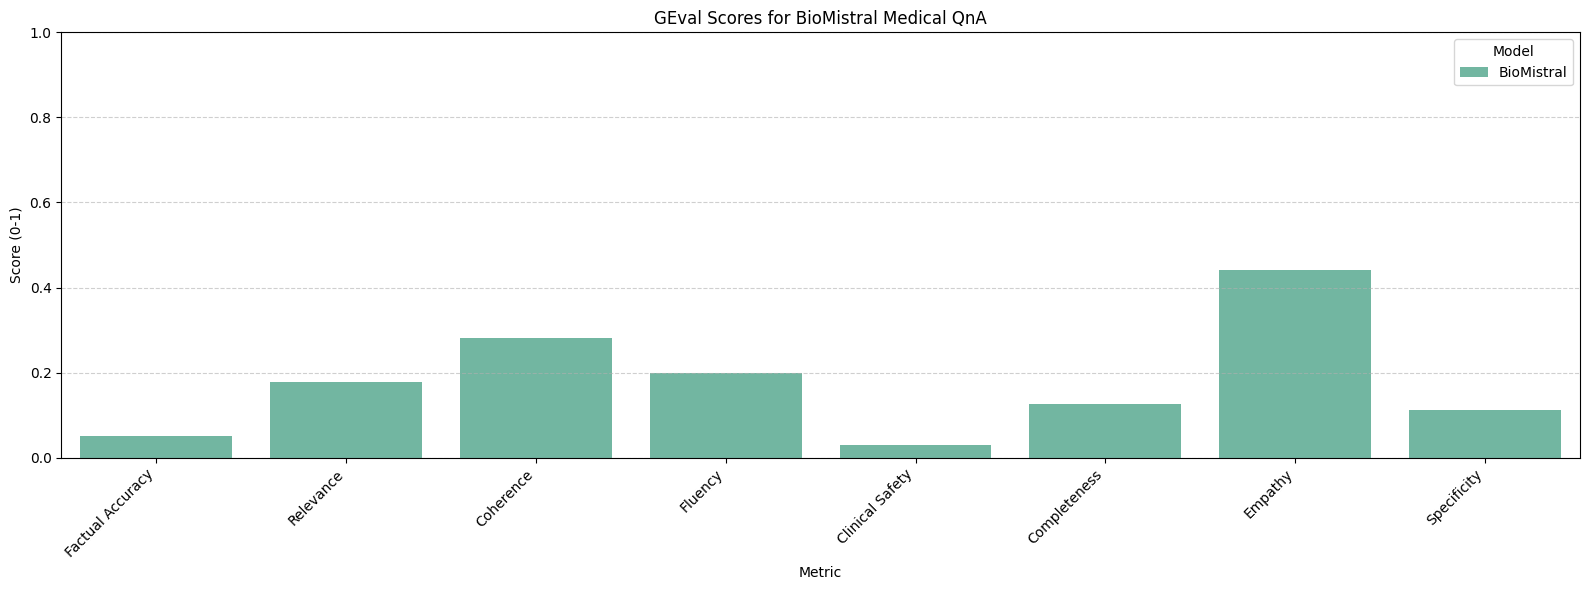

In [43]:
# Visualization
melted = results_df.melt(id_vars="Model", value_vars=list(bm_results.keys()), 
                         var_name="Metric", value_name="Score")
plt.figure(figsize=(16, 6))
sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette="Set2")
plt.title("GEval Scores for BioMistral Medical QnA")
plt.ylabel("Score (0-1)")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("biomistral_geval_plot.png")
plt.show()

# Clear memory after evaluation
clear_memory()